In [1]:
from itertools import product
import queue
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
from vacuum.util import AttrDict
%matplotlib inline

In [2]:
image_path = '/home/gijs/Pictures/background.jpg'

In [3]:
class IterableQueue(queue.Queue):
    def __iter__(self):
        while True:
            try:
               yield self.get_nowait()
            except queue.Empty:
               return

In [4]:
a = AttrDict()
a.size = 256
a.pad = 10

In [5]:
big_data = plt.imread(image_path)[:,:,1]
psf = big_data[0:255, 0:255]

```
definition

- stamp: a subsection of the dirty image
- padding: a region removed from a cleaned stamp on one or more sides
- stride: the amount of pixels between stamp, typically stamp size - 2 * padding

0,0         0,c
+------------+
|            +
|            +
|            +
|            +
|            +
+------------+
r,0         r,c

1> do all corners, aligning the corner of the image with the corner of the stamp
2> do the edges, only apply padding in direction of the edge
3> do full image, row by row, padding on all sides of stamp (0,0)->(r,0), (0,1)->(x,1), ... , (0,y)->(x,y)

note: it looks like numpy arrays flip x and y
```

In [6]:
TL = (slice(None, a.size), slice(None, a.size))
BL = (slice(-a.size, None), slice(None, a.size))
TR = (slice(None, a.size), slice(-a.size, None))
BR = (slice(-a.size, None), slice(-a.size, None))

stride = a.size - a.pad * 2
n_r = int(big_data.shape[0] / stride)
n_c = int(big_data.shape[1] / stride)
n_r = int(big_data.shape[0] / stride)
n_c = int(big_data.shape[1] / stride)


In [7]:
def padded_generator(big_data, psf, n_r, n_c):
    i = 0
    for r, c in (TL, TR, BL, BR):  # step 1
        print(f"cleaning {i}: {r}, {c}")
        stamp = big_data[r, c]
        yield i, stamp.min(), stamp.max(), psf, stamp
        i += 1

    for r in range(1, n_r):  # step 2: edges left right
        start = stride * r
        print(f"cleaning {i}: {start}:{start + a.size}, :{a.size}")
        stamp = big_data[start:start + a.size, :a.size]  # 0,0 -> r,0
        yield i, stamp.min(), stamp.max(), psf, stamp
        i += 1

        print(f"cleaning {i}: {start}:{start + a.size}, {-a.size}:")
        stamp = big_data[start:start + a.size, -a.size:]  # 0,c -> r,c
        yield i, stamp.min(), stamp.max(), psf, stamp
        i += 1

    for c in range(1, n_c):  # step 2: edges, top bottom
        start = stride * c
        print(f"cleaning {i}: :{a.size}, {start}:{start + a.size}")
        stamp = big_data[:a.size, start:start + a.size]  # 0,0 -> 0,c
        yield i, stamp.min(), stamp.max(), psf, stamp
        i += 1

        print(f"cleaning {i}: {-a.size}:, {start}:{start + a.size}")
        stamp = big_data[-a.size:, start:start + a.size]  # 0,0 -> r,c
        yield i, stamp.min(), stamp.max(), psf, stamp
        i += 1

    for r, c in product(range(1, n_r), range(1, n_c)):  # step 3
        start_r = stride * r
        start_c = stride * c
        print(f"cleaning {i}: {start_r}:{start_r + a.size}, {start_c}:{start_c + a.size}")
        stamp = big_data[start_r:start_r + a.size, start_c:start_c + a.size]
        yield i, stamp.min(), stamp.max(), psf, stamp
        i += 1

In [17]:
def restore(shape, generator, n_r, n_c):
    restored = np.zeros(shape=shape)

    print("step 1: corners")
    for r, c in (TL, TR, BL, BR):
        stamp = next(generator).squeeze()
        restored[r, c] = stamp

    print("step 2: edges")
    for r in range(1, n_r):
        start = stride * r
        stamp = next(generator).squeeze()[a.pad:-a.pad,:]
        restored[start + a.pad:start + a.size - a.pad, :a.size] = stamp
        stamp = next(generator).squeeze()[a.pad:-a.pad,:]
        restored[start + a.pad:start + a.size - a.pad, -a.size:] = stamp

    for c in range(1, n_c):
        start = stride * c
        stamp = next(generator).squeeze()[:,a.pad:-a.pad]
        restored[:a.size, start + a.pad:start + a.size - a.pad] = stamp
        stamp = next(generator).squeeze()[:,a.pad:-a.pad]
        restored[-a.size:, start + a.pad:start + a.size - a.pad] = stamp

    print("step 3: edges")
    for r, c in product(range(1, n_r), range(1, n_c)):
        start_r = stride * r
        start_c = stride * c
        stamp = next(generator).squeeze()[a.pad:-a.pad,a.pad:-a.pad]
        restored[start_r + a.pad:start_r + a.size - a.pad,
                 start_c + a.pad:start_c + a.size - a.pad] = stamp

    return restored

In [18]:
queue_ = IterableQueue()
for i in padded_generator(big_data, psf, n_r, n_c):
    queue_.put(i[4])

In [19]:
restored = restore(big_data.shape, iter(queue_), n_r, n_c)

step 1: corners
step 2: edges


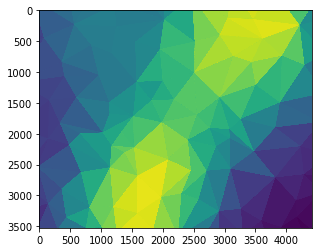

In [20]:
imgplot = plt.imshow(restored)